# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.preprocessing import LabelEncoder

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

pd.set_option('display.max_columns', 500)

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Exploratory Data Analysis and Cleaning Data

## First Profile Data

In [2]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [3]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [4]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [5]:
# there are missing values in income and gender features

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
# renaming 'id' column name to 'customer_id'.
profile.rename(columns={'id':'customer_id'},inplace=True)

In [8]:
# became_member_on is in int format, convert it to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [9]:
profile['year'] = profile['became_member_on'].dt.year

In [10]:
# GENDER COLUMN

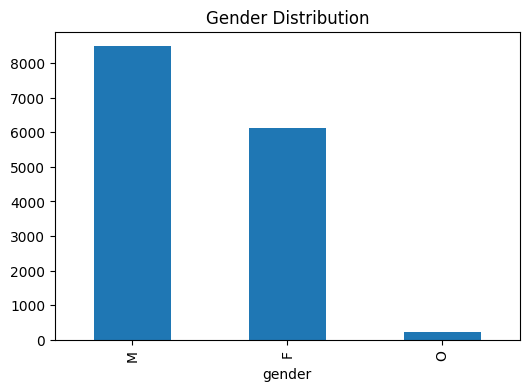

In [11]:
profile['gender'].value_counts().plot(kind='bar', figsize=(6, 4))
plt.title('Gender Distribution')
plt.show()

In [12]:
# INCOME COLUMN

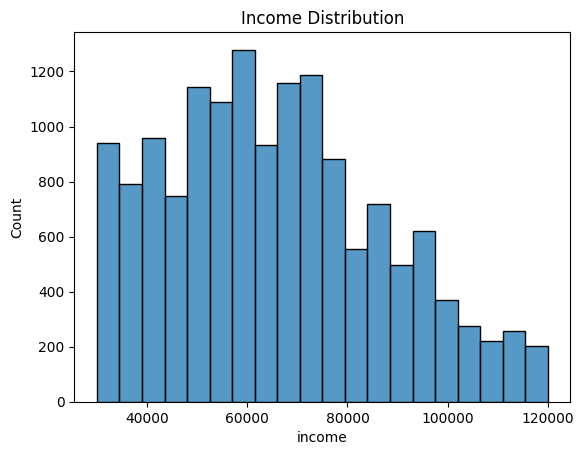

In [13]:
# lets see the distribution of income

sns.histplot(profile['income'], bins=20,)
plt.title('Income Distribution')
plt.show()

In [14]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [15]:
# AGE COLUMN

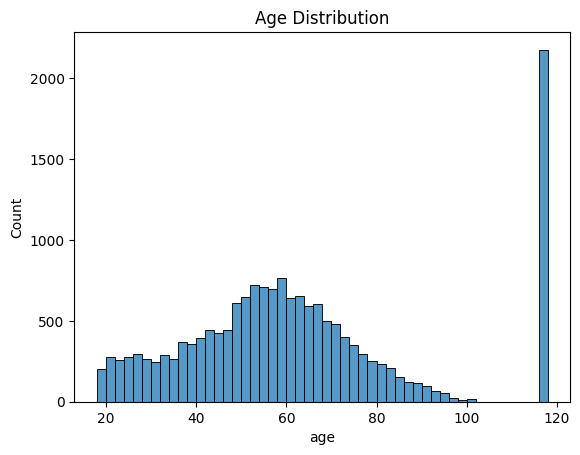

In [16]:
# lets see the distribution of age

sns.histplot(profile['age'], bins = 50)
plt.title('Age Distribution')
plt.show()

In [17]:
# 100 years old is not possible

profile[profile['age'] >= 100]['age'].count()

# we can replace 118 with NaN

profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

In [18]:
# lets drop rows with Null values in 'age', 'gender' and 'income' columns
profile.dropna(inplace=True)

In [19]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  float64       
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   year              14825 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 752.8+ KB


In [20]:
# lets plot to evaluate profile data

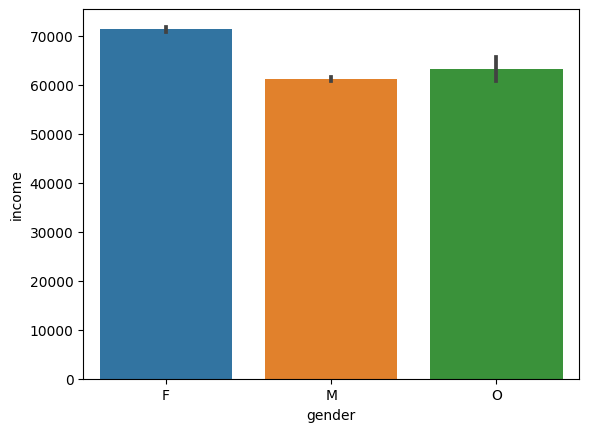

In [21]:
sns.barplot(x = 'gender', y = 'income', data = profile)
plt.show()

In [22]:
# F gender has the highest income, followed by M and O

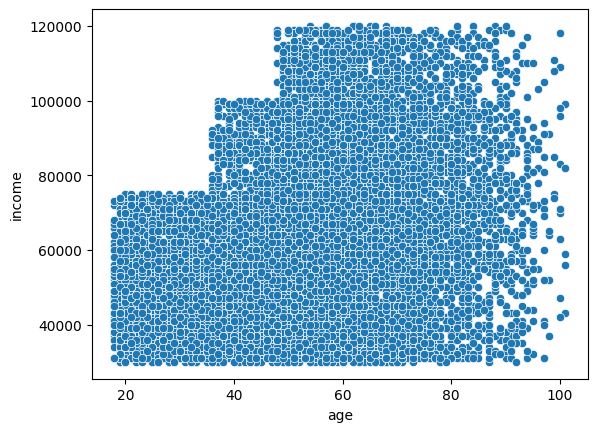

In [23]:
sns.scatterplot(x = 'age', y = 'income', data = profile)
plt.show()

In [24]:
# its interesting that there is a ladder pattern in the income. some young people thats age under 20 have high income

In [25]:
# lets convert gender column to dummy variables

profile['M'] = profile['gender'].map(lambda x: 'M' in x).astype(int)
profile['F'] = profile['gender'].map(lambda x: 'F' in x).astype(int)
profile['O'] = profile['gender'].map(lambda x: 'O' in x).astype(int)

In [26]:
profile.reset_index(drop=True, inplace=True)

In [27]:
profile.head()

,gender,age,customer_id,became_member_on,income,year,M,F,O
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0,1,0
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,0,1,0
2,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,1,0,0
3,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,1,0,0
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,1,0,0


## Second dataset: portfolio

In [28]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [29]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [30]:
# we should convert channels column to dummy variables

In [31]:
# lets create a new column for each channel
portfolio['email'] = portfolio['channels'].map(lambda x: 'email' in x).astype(int)
portfolio['mobile'] = portfolio['channels'].map(lambda x: 'mobile' in x).astype(int)
portfolio['social'] = portfolio['channels'].map(lambda x: 'social' in x).astype(int)
portfolio['web'] = portfolio['channels'].map(lambda x: 'web' in x).astype(int)

In [32]:
# we can drop channels column

portfolio.drop('channels', axis=1, inplace=True)

In [33]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [34]:
portfolio['id'].unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [35]:

portfolio['offer_id'] = pd.factorize(portfolio['id'])[0]



In [36]:
# lets dummy encode offer_type column
le = LabelEncoder()
portfolio['offer_type'] = le.fit_transform(portfolio['offer_type'])

# bogo: 0, informational: 2, discount: 1

In [37]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer_id
0,10,10,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0
1,10,10,5,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1
2,0,0,4,2,3f207df678b143eea3cee63160fa8bed,1,1,0,1,2
3,5,5,7,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,3
4,5,20,10,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,4
5,3,7,7,1,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,5
6,2,10,10,1,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,6
7,0,0,3,2,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,7
8,5,5,5,0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,8
9,2,10,7,1,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,9


## Last Exploring Transcript Data

In [38]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [39]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [40]:
# there is no missing values

In [41]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [42]:
def get_offer_id(value_dict):
    """
    This function retrieves the value of 'offer_id' or 'offer id' from a dictionary.
    If none of these keys exist in the dictionary, it returns None.

    Parameters:
    value_dict (dict): The dictionary to search for the keys.

    Returns:
    str: The value of 'offer_id' or 'offer id' key if it exists in the dictionary. 
         If neither exists, returns None.
    """

    for key in ['offer_id', 'offer id']:
        if key in value_dict:
            return value_dict[key]
    return None

transcript['offer_id'] = transcript['value'].apply(get_offer_id)

In [43]:

transcript.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [44]:
def extract_values_from_dict(df, column, keys):
    """
    This function searches for specific keys in a dictionary column of a DataFrame.
    If a key exists in a dictionary, it assigns the corresponding value to a new column with the same name as the key.
    If the key does not exist, it assigns None to the new column.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    column (str): The name of the column containing dictionaries to search for keys.
    keys (list): The list of keys to search for in the dictionaries.

    Returns:
    pd.DataFrame: The processed DataFrame with new columns for each key.
    """
    for key in keys:
        df[key] = df[column].apply(lambda x: x[key] if key in x else None)
    return df

keys_to_extract = ['reward', 'amount']
transcript = extract_values_from_dict(transcript, 'value', keys_to_extract)

In [45]:
transcript.head()

,person,event,value,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [46]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   value     306534 non-null  object 
 3   time      306534 non-null  int64  
 4   offer_id  167581 non-null  object 
 5   reward    33579 non-null   float64
 6   amount    138953 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB


In [47]:
transcript.isnull().sum()

person           0
event            0
value            0
time             0
offer_id    138953
reward      272955
amount      167581
dtype: int64

In [48]:
# lets impute missing values in 'offer_id' column with 'amount' column with 0 values

In [49]:
transcript.fillna(0,inplace=True)

In [50]:
transcript['reward'].value_counts()

reward
0.0     272955
5.0      12070
2.0       9334
10.0      7019
3.0       5156
Name: count, dtype: int64

In [51]:
# we dont need value column anymore

transcript.drop('value',axis=1,inplace=True)

In [52]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [53]:
# we dont need to transaction and offer received rows

transcript = transcript[~transcript['event'].isin(['transaction', 'offer received'])]

In [54]:
# encode event column

In [55]:
# creating LabelEncoder object
le = LabelEncoder()

# and encoding
transcript['encoded_event'] = le.fit_transform(transcript['event'])

In [56]:
transcript.reset_index(drop=True, inplace=True)

In [57]:
# ITS TİME TO MERGE DATAFRAMES

In [58]:
# merge 'clean_transcript' dataset with 'clean_portfolio' on 'offer_id'
df = transcript.merge(portfolio,how='left',left_on='offer_id', right_on='id')

In [59]:
# join 'master_df' dataset with 'clean_profile' on 'customer_id'
df = df.merge(profile,how ='left', left_on = 'person', right_on = 'customer_id')

In [60]:
df.head()

,person,event,time,offer_id_x,reward_x,amount,encoded_event,reward_y,difficulty,duration,offer_type,id,email,mobile,social,web,offer_id_y,gender,age,customer_id,became_member_on,income,year,M,F,O
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,1,5,5,5,0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018.0,1.0,0.0,0.0
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,1,0,0,3,2,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,7,O,53.0,d1ede868e29245ea91818a903fec04c6,2017-09-16,52000.0,2017.0,0.0,0.0,1.0
2,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,1,10,10,5,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,F,69.0,102e9454054946fda62242d2e176fdce,2016-08-14,57000.0,2016.0,0.0,1.0,0.0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,1,10,10,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0,F,20.0,02c083884c7d45b39cc68e1314fec56c,2016-07-11,30000.0,2016.0,0.0,1.0,0.0
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,1,0,0,3,2,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,7,M,39.0,be8a5d1981a2458d90b255ddc7e0d174,2014-05-27,51000.0,2014.0,1.0,0.0,0.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91304 entries, 0 to 91303
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   person            91304 non-null  object        
 1   event             91304 non-null  object        
 2   time              91304 non-null  int64         
 3   offer_id_x        91304 non-null  object        
 4   reward_x          91304 non-null  float64       
 5   amount            91304 non-null  float64       
 6   encoded_event     91304 non-null  int64         
 7   reward_y          91304 non-null  int64         
 8   difficulty        91304 non-null  int64         
 9   duration          91304 non-null  int64         
 10  offer_type        91304 non-null  int64         
 11  id                91304 non-null  object        
 12  email             91304 non-null  int64         
 13  mobile            91304 non-null  int64         
 14  social            9130

In [62]:
# lets drop null values

df = df.dropna(how='any',axis=0)

In [63]:
# lets organize columns

df.drop(['person', 'offer_id_x', 'id', 'customer_id', 'reward_y', 'email', 'amount'], axis=1, inplace=True)

In [64]:
df.rename(columns={'reward_x': 'reward'}, inplace=True)
df.rename(columns={'offer_id_y': 'offer_id'}, inplace=True)

In [65]:
df.head()

,event,time,reward,encoded_event,difficulty,duration,offer_type,mobile,social,web,offer_id,gender,age,became_member_on,income,year,M,F,O
0,offer viewed,0,0.0,1,5,5,0,1,1,1,8,M,65.0,2018-02-09,53000.0,2018.0,1.0,0.0,0.0
1,offer viewed,0,0.0,1,0,3,2,1,1,0,7,O,53.0,2017-09-16,52000.0,2017.0,0.0,0.0,1.0
2,offer viewed,0,0.0,1,10,5,0,1,1,1,1,F,69.0,2016-08-14,57000.0,2016.0,0.0,1.0,0.0
3,offer viewed,0,0.0,1,10,7,0,1,1,0,0,F,20.0,2016-07-11,30000.0,2016.0,0.0,1.0,0.0
4,offer viewed,0,0.0,1,0,3,2,1,1,0,7,M,39.0,2014-05-27,51000.0,2014.0,1.0,0.0,0.0


# continue exploratory data analysis

In [66]:
# lets see the correlation between columns. first, creating numeric columns list

numeric_columns = ['time', 'reward', 'difficulty', 'duration', 'offer_type', 'mobile', 'social', 'web', 'M', 'F', 'O', 'age', 'income', 'encoded_event']

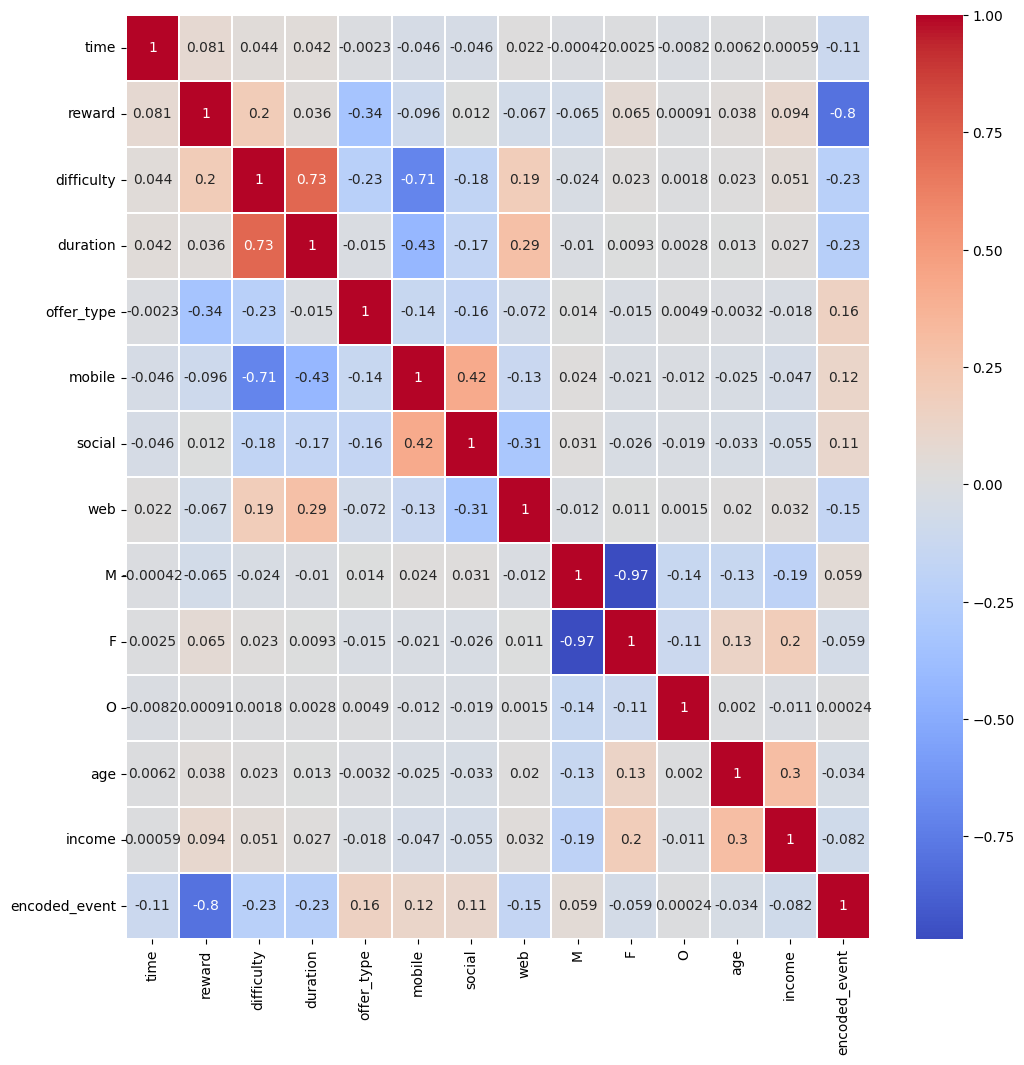

In [67]:
# lets see the correlation between columns

plt.figure(figsize=(12, 12))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

<Axes: xlabel='event', ylabel='age'>

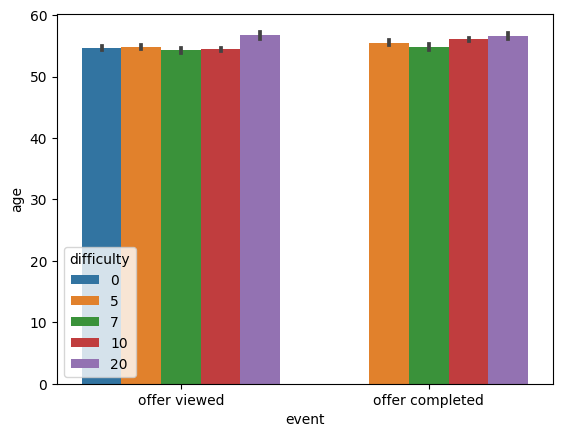

In [68]:
sns.barplot(x = 'event', y = 'age', data = df, estimator=np.mean, hue = 'difficulty')

In [69]:
# as we can see, almost same age groups complete and/or viewed the offers. there is no meaningful difference between them

<Axes: xlabel='gender', ylabel='encoded_event'>

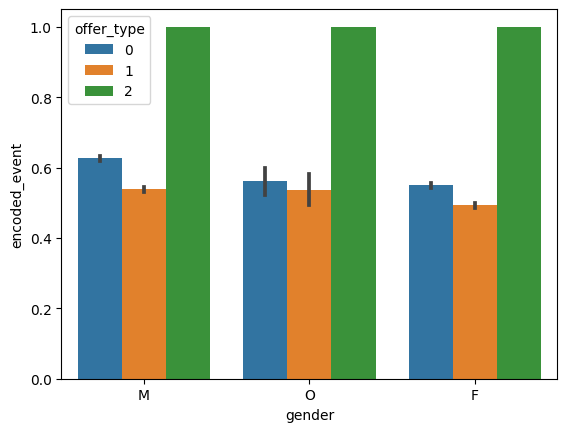

In [70]:
sns.barplot(x = 'gender', y = 'encoded_event', data = df, estimator=np.mean, hue = 'offer_type')

# bogo: 0, informational: 2, discount: 1

In [71]:
# we can see almost same distribution above. M gender and offer type 0 has the highest mean value

<Axes: xlabel='event', ylabel='difficulty'>

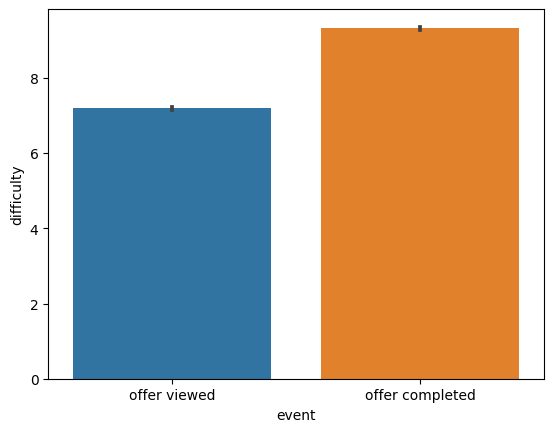

In [72]:
sns.barplot(x = 'event', y = 'difficulty', data = df, estimator=np.mean)

In [73]:
# as we can see, offer completed has the highest mean value as difficulty

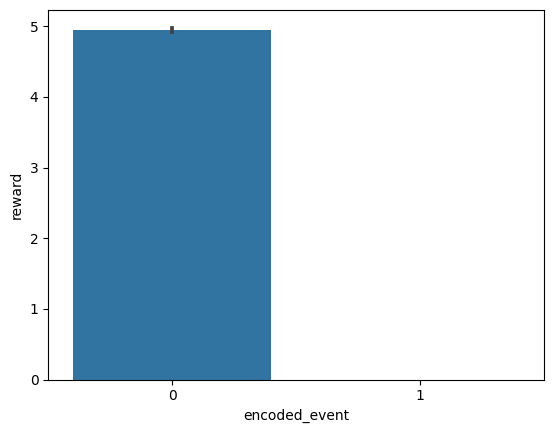

In [74]:
sns.barplot(x = 'encoded_event', y = 'reward', data = df, estimator=np.mean)
plt.show()

# MODELLING

In [75]:
df.columns

Index(['event', 'time', 'reward', 'encoded_event', 'difficulty', 'duration',
       'offer_type', 'mobile', 'social', 'web', 'offer_id', 'gender', 'age',
       'became_member_on', 'income', 'year', 'M', 'F', 'O'],
      dtype='object')

In [76]:
# target is encoded_event column

df.drop(['event', 'age', 'became_member_on', 'year', 'gender'], axis=1, inplace=True)

In [77]:
df.head()

,time,reward,encoded_event,difficulty,duration,offer_type,mobile,social,web,offer_id,income,M,F,O
0,0,0.0,1,5,5,0,1,1,1,8,53000.0,1.0,0.0,0.0
1,0,0.0,1,0,3,2,1,1,0,7,52000.0,0.0,0.0,1.0
2,0,0.0,1,10,5,0,1,1,1,1,57000.0,0.0,1.0,0.0
3,0,0.0,1,10,7,0,1,1,0,0,30000.0,0.0,1.0,0.0
4,0,0.0,1,0,3,2,1,1,0,7,51000.0,1.0,0.0,0.0


In [78]:
X = df[['time','difficulty','duration','offer_type','M','F','O','mobile', 'social', 'web', 'offer_id','income', 'reward']]
Y = df['encoded_event']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [80]:
# first i will try basic xgboost model
model = xgb.XGBClassifier()

In [81]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [82]:
pred = model.predict(X_test)

In [83]:
accuracy_score(y_test, pred)

1.0

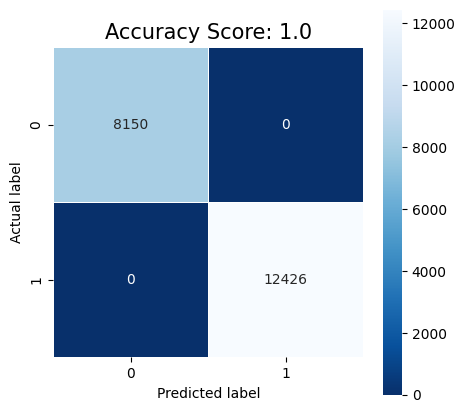

In [84]:
# plot confusion matrix
# 
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, pred))
plt.title(all_sample_title, size = 15);
plt.show() 

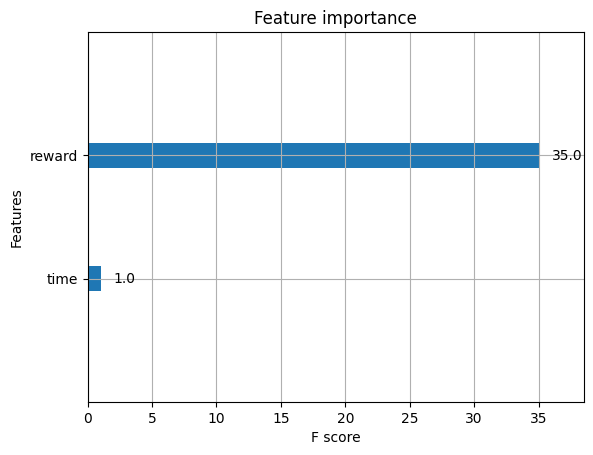

In [85]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

In [86]:
# no need to feature selection and hyperparameter tuning. because we have already good accuracy score but i will remove reward column and try again. because i think this model has overfitting problem

In [87]:
df.drop(['reward'], axis=1, inplace=True)

In [88]:
X = df[['time','difficulty','duration','offer_type','M','F','O','mobile', 'social', 'web', 'offer_id','income']]
Y = df['encoded_event']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [90]:
# again i will try basic xgboost model

In [91]:
first_model = xgb.XGBClassifier()

first_model.fit(X_train, y_train)

pred = first_model.predict(X_test)

accuracy_score(y_test, pred)

0.692603032659409

In [92]:
# i will try early stopping rounds

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dtest, 'eval')]

params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 3,
    'learning_rate': 0.15,
    'alpha': 0.1,
    'subsample': 0.9,
}
    
num_rounds = 500


In [93]:
model = xgb.train(params, dtrain, num_rounds, evals, early_stopping_rounds=10)

[0]	train-mlogloss:1.01549	eval-mlogloss:1.01597
[1]	train-mlogloss:0.95014	eval-mlogloss:0.95088
[2]	train-mlogloss:0.89699	eval-mlogloss:0.89804
[3]	train-mlogloss:0.85312	eval-mlogloss:0.85440
[4]	train-mlogloss:0.81688	eval-mlogloss:0.81830


/opt/miniconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[5]	train-mlogloss:0.78621	eval-mlogloss:0.78788
[6]	train-mlogloss:0.76027	eval-mlogloss:0.76231
[7]	train-mlogloss:0.73301	eval-mlogloss:0.73494
[8]	train-mlogloss:0.71261	eval-mlogloss:0.71485
[9]	train-mlogloss:0.69423	eval-mlogloss:0.69663
[10]	train-mlogloss:0.67922	eval-mlogloss:0.68177
[11]	train-mlogloss:0.66359	eval-mlogloss:0.66597
[12]	train-mlogloss:0.65137	eval-mlogloss:0.65391
[13]	train-mlogloss:0.64115	eval-mlogloss:0.64397
[14]	train-mlogloss:0.63101	eval-mlogloss:0.63392
[15]	train-mlogloss:0.62296	eval-mlogloss:0.62610
[16]	train-mlogloss:0.61584	eval-mlogloss:0.61924
[17]	train-mlogloss:0.60810	eval-mlogloss:0.61143
[18]	train-mlogloss:0.60244	eval-mlogloss:0.60600
[19]	train-mlogloss:0.59706	eval-mlogloss:0.60073
[20]	train-mlogloss:0.59176	eval-mlogloss:0.59551
[21]	train-mlogloss:0.58721	eval-mlogloss:0.59109
[22]	train-mlogloss:0.58323	eval-mlogloss:0.58721
[23]	train-mlogloss:0.57964	eval-mlogloss:0.58376
[24]	train-mlogloss:0.57647	eval-mlogloss:0.58081
[25]	

In [94]:
dnew = xgb.DMatrix(X_test)

pred = model.predict(dnew)

In [95]:
accuracy_score(y_test, pred)

0.7004762830482115

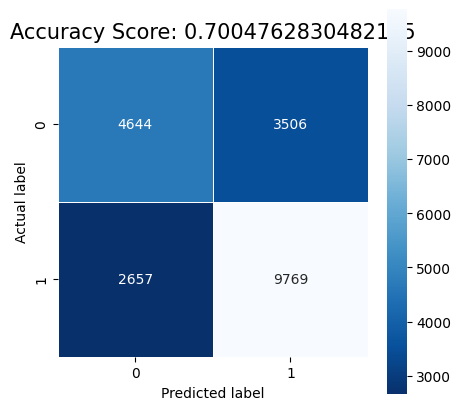

In [96]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, pred))
plt.title(all_sample_title, size = 15);
plt.show() 

# Conclusion

First, I took a close look at each dataset and visualized them to better understand the data. This also involved examining different parts of the data. After that, I started with the Data Preprocessing. This step was the most time-consuming and challenging part. The datasets were a bit complex and required a lot of wrangling, engineering, and preprocessing to get the final clean version. 

With the whole feature set of the model, the xgboost classifier provided 100% accuracy score. I think the model will get very bad scores for a dataset that it has never seen. 100% accuracy score is not a preferred result for any model. When we made feature importance for xgboost, I saw that the 'reward' variable had a very high f1 score. In order to prevent overfitting, I removed this feature and set up the model again and this time I used a learning curve. After removing the 'reward' variable, the accuracy score was 69% with the base model, and it was updated to 70% after the learning curve.